In [ ]:
#ディリクレ過程を使ったクラスタリングの基本プログラム
#2021年1月21日から多次元に拡張して作成

In [1]:
from __future__ import print_function
import argparse
import torch
from torch.utils import data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np


from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

import math

import os
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable


import glob
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split
import pickle
import copy

In [593]:
initial_data_dim = 3
real_cluster_number =20
center_std = 3
data_std = 0.3
N_data_one_cluster =100

In [594]:
#n次元中の中心を決める
cluster_centers = center_std*np.random.randn(real_cluster_number,initial_data_dim)
distribution = data_std*np.random.randn(N_data_one_cluster,real_cluster_number,initial_data_dim)
distribution.shape,np.repeat(cluster_centers[None,:],N_data_one_cluster,axis=0).shape
X_data = distribution+np.repeat(cluster_centers[None,:],N_data_one_cluster,axis=0)
ts =np.repeat(np.arange(real_cluster_number),N_data_one_cluster)

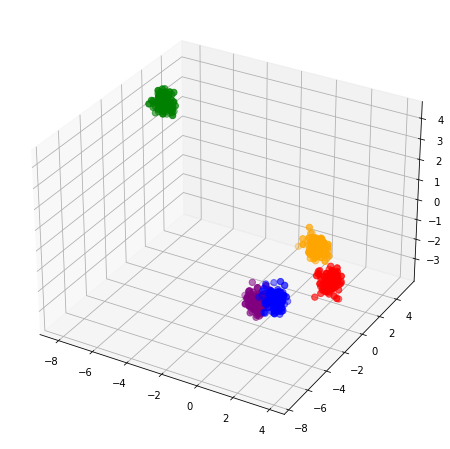

In [595]:
# Figureを追加
fig = plt.figure(figsize = (8, 8))
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_data[:,0,0], X_data[:,0,1], X_data[:,0,2], s = 40, c = "blue")
ax.scatter(X_data[:,1,0], X_data[:,1,1], X_data[:,1,2], s = 40, c = "red")
ax.scatter(X_data[:,2,0], X_data[:,2,1], X_data[:,2,2], s = 40, c = "green")
ax.scatter(X_data[:,3,0], X_data[:,3,1], X_data[:,3,2], s = 40, c = "purple")
ax.scatter(X_data[:,4,0], X_data[:,4,1], X_data[:,4,2], s = 40, c = "orange")

In [596]:
X_data_concat = X_data[:,0,:]
for i in range(1,X_data.shape[1]):
    X_data_concat = np.concatenate([X_data_concat,X_data[:,i,:]],axis=0)
X_data_concat.shape

(2000, 3)

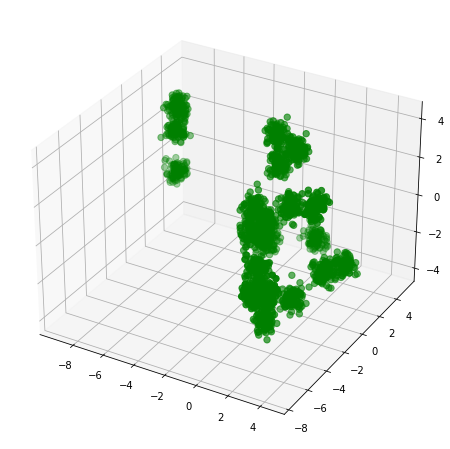

In [597]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_data_concat[:,0], X_data_concat[:,1], X_data_concat[:,2], s = 40, c = "green")
plt.show()

In [598]:
random_label = np.random.permutation(np.arange(X_data_concat.shape[0]))
X_2d_p_data = X_data_concat[random_label]
ts_p_data = ts[random_label]

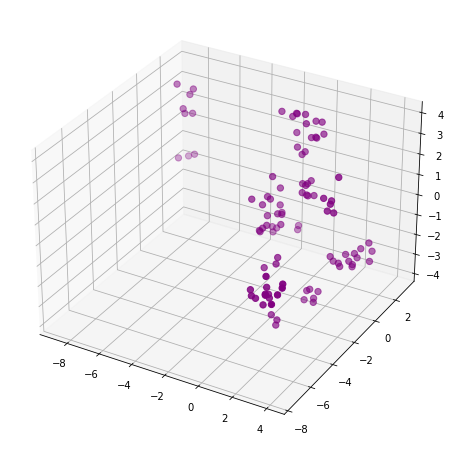

In [599]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_2d_p_data[:100,0], X_2d_p_data[:100,1], X_2d_p_data[:100,2], s = 40, c = "purple")
plt.show()

In [59]:
def log_P_func(l_f,latent_data_f,pick_up_number_f,dirichlet_alpha_f,pre_nu_f,pre_beta_f,pre_mu_0_f,S_0_inv_f):

    cluster_data = latent_data_f[l_f]
    cluster_center = cluster_data.mean(axis=0)
    n_prime = len(l_f)
    mu_c = (n_prime*cluster_center+pre_beta_f*pre_mu_0_f)/(n_prime+pre_beta_f)
#    mu_c = n_prime*cluster_center
#    mu_c +=pre_beta_f*pre_mu_0_f
#    mu_c/=(n_prime+pre_beta_f)

    S_q_inv = S_0_inv_f + n_prime*np.cov(cluster_data,rowvar=0,bias=1) + n_prime*pre_beta_f*np.outer(cluster_center-pre_mu_0_f,cluster_center-pre_mu_0_f)/(n_prime + pre_beta_f)
    S_r_inv = S_q_inv + (n_prime + pre_beta_f)*np.outer(latent_data_f[pick_up_number_f]-mu_c,latent_data_f[pick_up_number_f]-mu_c)/(n_prime + pre_beta_f+1)
    data_dim = latent_data_f[pick_up_number_f].shape[0]
    n_total = latent_data_f.shape[0]
#    print("n_prime={}".format(n_prime))
#    print("cluster_center={}".format(cluster_center))
#    print("mu_c={}".format(mu_c))
#    print("S_q_inv={}".format(S_q_inv))
#    print("S_r_inv={}".format(S_r_inv))
#    print("data_dim={}".format(data_dim))
#    print("n_total={}".format(n_total))

#    return S_r_inv,S_q_inv
#    return np.log(n_prime/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log((n_prime+pre_beta_f)/(n_prime+pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + n_prime +1)*np.log(S_r_inv)+0.5*(pre_nu_f + n_prime)*np.log(S_q_inv)+math.lgamma(0.5*(pre_nu_f+n_prime+1))-math.lgamma(0.5*(pre_nu_f+n_prime+1-data_dim))
    return np.log(n_prime/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log((n_prime+pre_beta_f)/(n_prime+pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + n_prime +1)*np.log(np.linalg.det(S_r_inv))+0.5*(pre_nu_f + n_prime)*np.log(np.linalg.det(S_q_inv))+math.lgamma(0.5*(pre_nu_f+n_prime+1))-math.lgamma(0.5*(pre_nu_f+n_prime+1-data_dim))


def log_P_new_func(latent_data_f,pick_up_number_f,dirichlet_alpha_f,pre_nu_f,pre_beta_f,pre_mu_0_f,S_0_inv_f):

    picked_data = latent_data_f[pick_up_number_f]
    S_b_inv = S_0_inv_f + pre_beta_f*np.outer(picked_data-pre_mu_0_f,picked_data-pre_mu_0_f)/(pre_beta_f+1)
    data_dim = picked_data.shape[0]
    n_total = latent_data_f.shape[0]

#    print("S_0_inv={}".format(S_0_inv_f))
#    print("S_b_inv={}".format(S_b_inv))
#    print("data_dim={}".format(data_dim))
#    print("n_total={}".format(n_total))

    return np.log(dirichlet_alpha_f/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log(pre_beta_f/(pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + 1)*np.log(np.linalg.det(S_b_inv))+0.5*pre_nu_f*np.log(np.linalg.det(S_0_inv_f))+math.lgamma(0.5*(pre_nu_f+1))-math.lgamma(0.5*(pre_nu_f+1-data_dim))
#    return np.log(dirichlet_alpha_f/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log(pre_beta_f/(pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + 1)*np.log(S_b_inv)+0.5*pre_nu_f*np.log(S_0_inv_f)+math.lgamma(0.5*(pre_nu_f+1))-math.lgamma(0.5*(pre_nu_f+1-data_dim))

In [60]:
def sum_del_log_gamma(nu,n,dim):
    x=0
    for i in range(dim):
       x+= math.lgamma(0.5*(nu+n-i))-math.lgamma(0.5*(nu-i))
    return x

def log_P_total(list_list,latent_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    cluster_number = len(list_list)
    data_dim = latent_data[0].shape[0]
    n_total = latent_data.shape[0]

    log_P = cluster_number*np.log(dirichlet_alpha)-math.lgamma(dirichlet_alpha+n_total)+ math.lgamma(dirichlet_alpha)
    for l in list_list:
        number_in_cluster = len(l)
        data_l = latent_data[l]
        data_l_av = data_l.mean(axis=0)
        S_q_inv = S_0_inv + number_in_cluster*np.cov(data_l,rowvar=0,bias=1)+ number_in_cluster*pre_beta*np.outer(data_l_av-pre_mu_0,data_l_av-pre_mu_0)/(number_in_cluster+pre_beta)
#        log_P += math.lgamma(number_in_cluster) -0.5*(pre_nu+number_in_cluster)*np.log(S_q_inv) +0.5*pre_nu*np.log(S_0_inv)+sum_del_log_gamma(pre_nu,number_in_cluster,data_dim)+0.5*data_dim*(np.log(pre_beta/(number_in_cluster+pre_beta))-number_in_cluster*np.log(math.pi))
        log_P += math.lgamma(number_in_cluster) -0.5*(pre_nu+number_in_cluster)*np.log(np.linalg.det(S_q_inv)) +0.5*pre_nu*np.log(np.linalg.det(S_0_inv))+sum_del_log_gamma(pre_nu,number_in_cluster,data_dim)+0.5*data_dim*(np.log(pre_beta/(number_in_cluster+pre_beta))-number_in_cluster*np.log(math.pi))

    return log_P

In [61]:
def softmax(a):
    # 一番大きい値を取得
    c = np.max(a)
    # 各要素から一番大きな値を引く（オーバーフロー対策）
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    # 要素の値/全体の要素の合計
    y = exp_a / sum_exp_a
    return y

In [62]:
def cluster_prob(list_list,latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    for l in list_list:
        if pick_up_number in l:
            current_place = list_list.index(l)
            list_list[current_place].remove(pick_up_number)

    for x in list_list:
        if x == []:
#            disappearing_index = list_list.index(x)
            list_list.remove(x)

    log_P = np.empty(len(list_list)+1)
    for i, l in enumerate(list_list):
        log_P[i] = log_P_func(l,latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)

    log_P[len(list_list)] = log_P_new_func(latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)

    return softmax(log_P)

In [63]:
def show_mean_cov(X_data,list_list):

    N_cluster = len(list_list)
    for i in range(N_cluster):
        X_0 = X_data[list_list[i]]
        print("--cluster{}--".format(i))
        print("N_member_{}={}".format(i,len(list_list[i])))
        print("Mean_{}={}".format(i,X_0.mean(axis=0)))
        print("Cov_{}=\n{}\n".format(i,np.cov(X_0,rowvar=0,bias=1)))


In [64]:
cm = plt.cm.get_cmap('tab20')
def drawpoints_with_centers(mus_numpy,ts_numpy,list_list):
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])

    N_cluster = len(list_list)
    X_mean = np.empty([N_cluster,2])
    for i in range(N_cluster):
        X_mean[i] = mus_numpy[list_list[i]].mean(axis=0)
    for p in X_mean:
        plt.scatter(p[0],p[1],facecolors='none',edgecolors='red',s=200)
    for i, p in enumerate(X_mean):
        plt.scatter(p[0],p[1],marker="${}$".format(i),color='black',s=50)
    plt.show()

In [119]:
cm = plt.cm.get_cmap('tab20')
def drawpoints_3d(mus_numpy,ts_numpy):
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection='3d')
#    for i in range(len(list_list)):
#        ax.scatter(mus_numpy[list_list[i],0], mus_numpy[list_list[i],1], mus_numpy[list_list[i],2], s = 40, color=cm.colors[i])
    for p,l in zip(mus_numpy,ts_numpy):
        ax.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])

    plt.show()

In [ ]:
def clustering_index(list_list):

    total_N =0
    for l in list_list:
        total_N += len(l)

    ts = np.empty(total_N)
    for i, l in enumerate(list_list):
        ts[l] = i

    return ts.astype(int)

In [66]:
def one_epoch(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):
    for pick_up_index in range(X_data.shape[0]):
        probability = cluster_prob(list_list,X_data,pick_up_index,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
        selected_cluster = np.random.choice(a=np.arange(len(list_list)+1),size=1,p=probability).item()
        if selected_cluster == len(list_list):
            list_list.append([pick_up_index])
        else:
            list_list[selected_cluster].append(pick_up_index)

In [67]:
def clustering(epoch_max,stopping_epoch,list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    best_log_P = log_P_total(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
    best_list_list =  copy.deepcopy(list_list)
    k=0
    for i in range(epoch_max):
        one_epoch(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
        print("i={},k={},N_cluster={},clustering_numbers = {}".format(i,k,len(list_list),[len(l) for l in list_list]))
        k+=1
        if log_P_total(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv) > best_log_P:
            best_log_P=log_P_total(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
            best_list_list =  copy.deepcopy(list_list)
            print("best value is updated. best_log_p={},N_cluster={}".format(best_log_P,len(best_list_list)))
            k=0
        if k == stopping_epoch:
            break

    return best_log_P,best_list_list,i




In [652]:
dirichlet_alpha_g = 1.
pre_nu_g =10.
pre_beta_g =0.01
pre_mu_0_g =np.mean(X_2d_p_data,axis=0)
S_0_inv_g = 10.*np.linalg.inv(np.cov(X_2d_p_data,rowvar=0,bias=1))
#S_0_inv_g = 20.*np.eye(initial_data_dim)

#grouping = [list(range(X_2d_p_data.shape[0]))]
grouping = []
for i in range(200):
    grouping.append([m for m in range(10*i,10*i+10)])
grouping_temp = copy.deepcopy(grouping)
#grouping_temp

In [671]:
dirichlet_alpha_g = 0.1
best_log_prob,best_labeling,best_time=clustering(500,100,grouping_temp,X_2d_p_data,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
#one_epoch(grouping_temp,X_2d_p_data,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
#len(grouping_temp),log_P_total(grouping_temp,X_2d_p_data,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
len(best_labeling),best_log_prob,best_time,[len(l) for l in best_labeling]

i=0,k=0,N_cluster=20,clustering_numbers = [100, 100, 101, 97, 101, 106, 100, 100, 100, 103, 100, 99, 98, 100, 105, 95, 100, 100, 100, 95]
best value is updated. best_log_p=-7904.835115579645,N_cluster=20
i=1,k=0,N_cluster=20,clustering_numbers = [101, 100, 102, 100, 99, 107, 100, 100, 100, 100, 100, 98, 99, 100, 101, 98, 100, 100, 100, 95]
i=2,k=1,N_cluster=20,clustering_numbers = [103, 100, 103, 99, 101, 106, 100, 100, 100, 101, 100, 97, 98, 100, 102, 95, 100, 100, 100, 95]
i=3,k=2,N_cluster=20,clustering_numbers = [103, 100, 96, 102, 101, 114, 100, 100, 100, 98, 100, 103, 105, 101, 99, 98, 100, 100, 100, 80]
i=4,k=3,N_cluster=20,clustering_numbers = [103, 100, 93, 100, 101, 115, 100, 100, 100, 100, 100, 106, 103, 101, 98, 99, 100, 100, 100, 81]
i=5,k=4,N_cluster=20,clustering_numbers = [101, 100, 99, 99, 103, 113, 100, 100, 100, 101, 100, 101, 102, 100, 100, 99, 100, 100, 100, 82]
i=6,k=5,N_cluster=20,clustering_numbers = [100, 100, 101, 96, 102, 112, 100, 100, 100, 104, 100, 99, 99,

(20,
 -7891.345681343204,
 226,
 [95,
  100,
  106,
  97,
  100,
  97,
  100,
  100,
  100,
  103,
  100,
  93,
  101,
  101,
  106,
  99,
  100,
  100,
  100,
  102])

In [672]:
#show_mean_cov(X_2d_p_data,grouping_temp)
show_mean_cov(X_2d_p_data,best_labeling)

--cluster0--
N_member_0=95
Mean_0=[-1.16288525  1.68886104  3.58166331]
Cov_0=
[[ 0.08808431 -0.01663856  0.0087542 ]
 [-0.01663856  0.09486193 -0.00993373]
 [ 0.0087542  -0.00993373  0.08116103]]

--cluster1--
N_member_1=100
Mean_1=[ 3.37642417 -6.79482037  0.21327132]
Cov_1=
[[ 0.09108724 -0.01516835 -0.00112709]
 [-0.01516835  0.08601813  0.00642536]
 [-0.00112709  0.00642536  0.08037387]]

--cluster2--
N_member_2=106
Mean_2=[ 2.97654973 -0.03794668 -1.96965835]
Cov_2=
[[ 0.0868021   0.00516168 -0.00188795]
 [ 0.00516168  0.08629326  0.01585142]
 [-0.00188795  0.01585142  0.09360186]]

--cluster3--
N_member_3=97
Mean_3=[-7.80643942  1.81173676  2.26468592]
Cov_3=
[[ 0.07348254  0.00909666 -0.00272642]
 [ 0.00909666  0.07816945 -0.00773414]
 [-0.00272642 -0.00773414  0.06742209]]

--cluster4--
N_member_4=100
Mean_4=[0.57723177 0.29989034 0.75796131]
Cov_4=
[[ 0.07649688 -0.00121917 -0.01453528]
 [-0.00121917  0.11506065  0.00566741]
 [-0.01453528  0.00566741  0.0858606 ]]

--cluster5

In [673]:
ts_p_data[best_labeling[9]]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 2, 2, 2, 2, 9, 9,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
drawpoints_3d(X_2d_p_data,clustering_index(best_labeling))

In [ ]:
kmeans_model = KMeans(n_clusters=real_cluster_number, random_state=1).fit(X_2d_p_data)
drawpoints_3d(X_2d_p_data,kmeans_model.labels_)

In [ ]:
gauss_model = GaussianMixture(n_components=real_cluster_number,covariance_type='full',random_state=1).fit(X_2d_p_data)
drawpoints_3d(X_2d_p_data,gauss_model.predict(X_2d_p_data))

In [ ]:
points = TSNE(n_components=2,random_state=0).fit_transform(X_2d_p_data)
drawpoints_with_centers(points,clustering_index(best_labeling),best_labeling)


In [ ]:
kmeans_model_afterTNSE = KMeans(n_clusters=real_cluster_number, random_state=1).fit(points)
drawpoints_with_centers(points,kmeans_model_afterTNSE.labels_,best_labeling)
drawpoints_with_centers(points,kmeans_model.labels_,best_labeling)

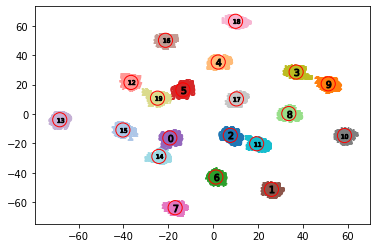

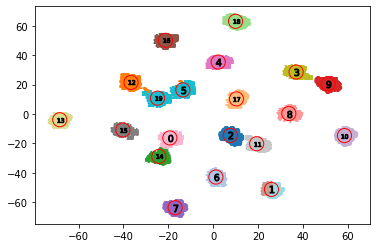

In [661]:
gauss_model_afterTNSE  = GaussianMixture(n_components=real_cluster_number,covariance_type='full',random_state=1).fit(points)
drawpoints_with_centers(points,gauss_model_afterTNSE.predict(points),best_labeling)
drawpoints_with_centers(points,gauss_model.predict(X_2d_p_data),best_labeling)